# word2vec (Skipgram)

## 1.Load data

### import library

In [1]:
import numpy as np 
import torch 
import torch.nn as nn
import torch.optim as optim 
import matplotlib.pyplot as plt 
import spacy
import pandas as pd 
import time 
import itertools
from numpy import dot
from numpy.linalg import norm
nlp = spacy.load("en_core_web_sm")

### Load corpus data from text file

In [2]:
f = ((open("questions-words.txt", "r")).read()).split(":")
corpus_syntactic = (f[14]).split("\n")[1:-1] # Singular and Plural Verbs
corpus_semantic = (f[5]).split("\n")[1:-1] # Family [boy, girl, brother, sister]

corpus = corpus_semantic + corpus_syntactic #All corpus
word = [[corpus[i]] for i in range(len(corpus))] #extract the data

corpus_syntactic = [[corpus_syntactic[i]] for i in range(len(corpus_syntactic))] #contain the corpus in list
corpus_semantic = [[corpus_semantic[i]] for i in range(len(corpus_semantic))]

## 2.Tokenization

In [3]:
def tokenize(corpus_input) : #Tokenize function by using spacy
    corpus_tokenizedd = []
    for token in corpus_input : 
        spare = []
        for ss in nlp(str(token[0])) :
            spare.append(str(ss))
        corpus_tokenizedd.append(spare)    
    return corpus_tokenizedd  

In [4]:
corpus_tokenized = tokenize(word)
cor_sem_token = tokenize(corpus_semantic) # Tokenize the data that use to test syntactic and semantic accuracy
cor_syn_token = tokenize(corpus_syntactic)

Affter tokenize data with look like this krub  ```[['boy', 'girl', 'brother', 'sister'], ['boy', 'girl', 'brothers', 'sisters']]```

In [5]:
flatten = lambda l: [item for sublist in l for item in sublist]
vocabs  = list(set(flatten(corpus_tokenized)))
vocabs_syn  = list(set(flatten(cor_syn_token)))
vocabs_sem  = list(set(flatten(cor_sem_token)))

In [6]:
vocabs[0:5] #show example of vocabs

['sister', 'vanishes', 'decrease', 'generate', 'woman']

## 3.Numerization

In [7]:
word_2_idx = {v: idx for idx, v in enumerate(vocabs)}
vocabs.append('<UNK>')
word_2_idx['<UNK>'] = len(word_2_idx) 

In [8]:
dict(itertools.islice(word_2_idx.items(), 10)) #

{'sister': 0,
 'vanishes': 1,
 'decrease': 2,
 'generate': 3,
 'woman': 4,
 'grandma': 5,
 'vanish': 6,
 'write': 7,
 'stepdaughter': 8,
 'policeman': 9}

## 4.Prepare data

In [9]:
def random_batch_skipgram(batch_size, corpus_tokenized):
    
    Skipgram = []

    #for each corpus
    for sent in corpus_tokenized:
        try :
            for i in range(1, len(sent) - 1): #start from 1 to second last
                center_word = word_2_idx[sent[i]]
                outside_words = [word_2_idx[sent[i-1]], word_2_idx[sent[i+1]]]  #window_size = 1
                for o in outside_words:
                    Skipgram.append([center_word, o]) #use outside word to predict center word
        except :
            pass               
    #only get a batch, not the entire list
    random_inputs, random_labels = [], []   
    random_index = np.random.choice(range(len(Skipgram)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    for index in random_index:
        random_inputs.append([Skipgram[index][0]])  
        random_labels.append([Skipgram[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)

## 5.Model

In [10]:
class Skipgram(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(Skipgram, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #convert them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     #(batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)   #(batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     #(batch_size, voc_size, emb_size)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        top_term_exp = torch.exp(top_term) 
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) 
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))

        
        return loss_fn

## 6. Train

In [11]:
voc_size = len(vocabs) #Size of vocabs
batch_size = 2 #Batch size 
emb_size   = 4 #Embeading size of 4
Skipgram   = Skipgram(voc_size, emb_size)
criterion  = nn.CrossEntropyLoss()  
optimizer  = optim.Adam(Skipgram.parameters(), lr=0.000108)
num_epochs = 5000

In [12]:
def prepare_sequence(seq, word2index):
    #map(function, list of something)
    #map will look at each of element in this list, and apply this function
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

all_vocabs = prepare_sequence(list(vocabs), word_2_idx).expand(batch_size, voc_size)
all_vocabs.shape #Shape of vocabs

torch.Size([2, 107])

In [13]:
def epoch_time(start_time, end_time):
    elapsed_time = (end_time - start_time)
    return elapsed_time

In [14]:
run_time_normal = 0
sum_time = 0
#for epoch
for epoch in range(num_epochs):
    start_time = time.time()

    #get random batch
    input_batch, label_batch = random_batch_skipgram(batch_size, corpus_tokenized)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    
    
    #loss = model
    loss = Skipgram(input_batch, label_batch, all_vocabs)
    #backpropagate
    loss.backward()
    #update alpha
    optimizer.step()
    stop_time = time.time()
    run_time_normal = run_time_normal + epoch_time(start_time, stop_time)
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        sum_time += run_time_normal
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {run_time_normal} s")
        run_time_normal = 0
print(f"sumary of time is : {sum_time} " )    

Epoch 1000 | Loss: 6.627711 | Time: 8.806552410125732 s
Epoch 2000 | Loss: 6.077048 | Time: 8.34883189201355 s
Epoch 3000 | Loss: 4.922022 | Time: 8.508143186569214 s
Epoch 4000 | Loss: 4.108150 | Time: 8.505576133728027 s
Epoch 5000 | Loss: 4.594633 | Time: 8.163592338562012 s
sumary of time is : 42.332695960998535 


## 7. Visualize Data (PCA)

In [15]:
def get_embed(word , model):
    
    try:
        index = word_2_idx[word]
    except:
        index = word_2_idx['<UNK>']
    
    word = torch.LongTensor([index])
    center_embed  = model.embedding_center_word(word)
    outside_embed = model.embedding_outside_word(word)
    embed = (center_embed + outside_embed) / 2
    
    return  [embed[0][i].item() for i in range(emb_size)]


In [16]:
words = []
for i, word in enumerate(vocabs[:40]): #loop each unique vocab
    words.append(word)
vec_word  = []


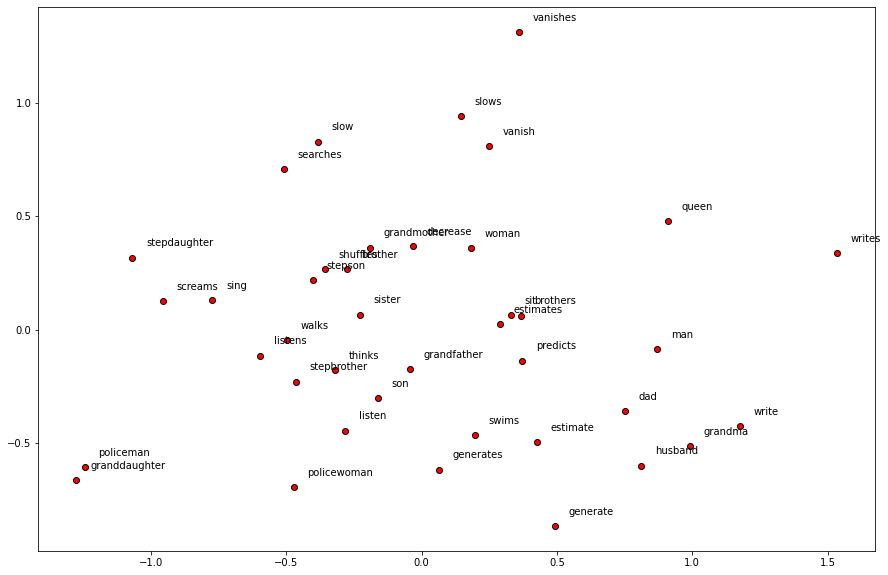

In [17]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
for oo in words :
    vec_word.append(np.array(get_embed(oo, Skipgram)))
word_vectors = vec_word
twodim = PCA().fit_transform(word_vectors)[:,:2]  #transform 4 to 2 dimensions

plt.figure(figsize=(15,10))
plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
for word, (x,y) in zip(words, twodim):
    plt.text(x+0.05, y+0.05, word)
plt.show()

## 8. Analogy

#### **“man is to king as woman is to queen”**

<img style="float: center;" src="https://carl-allen.github.io/assets/analogy/parallelogram2.svg">

In [18]:
vectors = { token:np.array(get_embed(token, Skipgram)) for token in vocabs } # write function to contain {token : array of token}
vectors_sementic = { token:np.array(get_embed(token, Skipgram)) for token in vocabs_sem }
vectors_syntactic = { token:np.array(get_embed(token, Skipgram)) for token in vocabs_syn }

In [19]:
dict(itertools.islice(vectors_sementic.items(), 5)) # show example of dictionary

{'grandfather': array([ 0.83694243,  0.59414077,  0.62368333, -0.45663542]),
 'sons': array([-0.00213587,  0.42554215,  0.77207243,  0.22305025]),
 'husband': array([0.07638786, 0.05400336, 0.76578677, 0.69274265]),
 'sister': array([ 0.66726297, -0.08422171, -0.22490735, -0.14483154]),
 'man': array([-0.11684401,  0.41454887,  0.42543805,  0.67782456])}

In [20]:
sum = (vectors["dad"]-vectors["mom"])+vectors["brothers"]

In [21]:
sum_value = np.dot(sum, vectors["brothers"]) / (np.linalg.norm(sum) * np.linalg.norm(vectors["brothers"]))
print(f" 'dad' - 'mom' + 'brothers' similarity to 'sister'  at {sum_value*100} percentage")

 'dad' - 'mom' + 'brothers' similarity to 'sister'  at 89.19128258040185 percentage


In [22]:
def analogy(x1, x2, y1, vectors):
    x1_vec, x2_vec, y1_vec = vectors[x1], vectors[x2], vectors[y1]
    result_vec = y1_vec + (x2_vec - x1_vec)
    result = closest_word(result_vec, vectors)
    return result

# function to find closest word to a given vector
def closest_word(vec, vectors):
    closest_idx = np.argmax([cosine_similarity(vec, v) for v in vectors.values()]) # use argmax to find the index of 
    return list(vectors.keys())[closest_idx]

# function to calculate cosine similarity
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

this code ``` np.argmax([cosine_similarity(vec, v) for v in vectors.values()] ``` use to find the most similarity from the result vector to vector of all vocabs

In [23]:
def test_senario(a1 , a2, model_l) :
    tester1 = get_embed(a1, model_l)
    teater2 = get_embed(a2, model_l)
    print(f"{a1} similarity to {a2} = {cosine_similarity(tester1 , teater2)}")

In [24]:
test_senario("provide","provides", Skipgram)


provide similarity to provides = 0.6381153619287986


In [25]:
analogy('eat', 'eats', 'listen', vectors)

'go'

In [26]:
analogy('he', 'she', 'stepson', vectors)

'plays'

In [27]:
def extract_word(word_m) :
    word_cc = []
    for value in word_m :
        temporary = []
        for indx in range (len(value)) :
            temporary.append(value[indx])
            if int(indx + 1) % int(2) == 0 :
                if temporary not in word_cc :
                    word_cc.append(temporary)
                temporary = []
    return word_cc            
            

In [28]:
semantic_word = extract_word(cor_sem_token)
syntactic_word = extract_word(cor_syn_token)

In [29]:
len(syntactic_word)

30

In [30]:
def acc_test (word_test , vector_target) :
    count = 0
    round = 0
    print(f"the correct word is : ")
    for tokens in word_test : # word_cc[0] look like this [decrease , decreases] then i loop and check analogy every word
        word1 = tokens[0]
        word2 = tokens[1]
        for ss in range (len(word_test)) :
            if str(word1) != str(word_test[ss][0]) :
                relt  = analogy( str(word1), str(word2), word_test[ss][0], vector_target)
                round = round+1
                if str(relt) == str(word_test[ss][1]) :
                    print(f'{word1} is to {word2} as {word_test[ss][0]} to {relt}')
                    count = count + 1     
            else : 
                pass        
    accuracy = (abs(count/round)) * 100        
    print(f"test {round} time correct {count} time, you accuracy is {accuracy :.2f} percentage")    
    return accuracy

this dataset have 30 pair of singular and phural verbs. When loop to check with every word should be 900 round but there are 30 pair that repeated.

In [31]:
skipgram_syn_acc = acc_test(syntactic_word, vectors_syntactic)

the correct word is : 
decrease is to decreases as eat to eats
describe is to describes as swim to swims
eat is to eats as decrease to decreases
enhance is to enhances as vanish to vanishes
estimate is to estimates as implement to implements
find is to finds as sit to sits
find is to finds as swim to swims
generate is to generates as predict to predicts
go is to goes as decrease to decreases
go is to goes as estimate to estimates
go is to goes as see to sees
implement is to implements as search to searches
implement is to implements as swim to swims
increase is to increases as eat to eats
increase is to increases as search to searches
increase is to increases as swim to swims
listen is to listens as implement to implements
listen is to listens as predict to predicts
listen is to listens as swim to swims
play is to plays as decrease to decreases
play is to plays as eat to eats
play is to plays as go to goes
predict is to predicts as implement to implements
predict is to predicts as swim

In [32]:
skipgram_sem_acc = acc_test(semantic_word, vectors_sementic)

the correct word is : 
boy is to girl as his to her
brother is to sister as grandson to granddaughter
brother is to sister as stepson to stepdaughter
dad is to mom as stepson to stepdaughter
father is to mother as grandpa to grandma
grandpa is to grandma as he to she
grandson is to granddaughter as stepson to stepdaughter
groom is to bride as grandfather to grandmother
groom is to bride as king to queen
groom is to bride as stepfather to stepmother
husband is to wife as grandfather to grandmother
husband is to wife as grandson to granddaughter
husband is to wife as nephew to niece
husband is to wife as stepson to stepdaughter
king is to queen as son to daughter
king is to queen as stepfather to stepmother
man is to woman as grandson to granddaughter
nephew is to niece as grandfather to grandmother
nephew is to niece as grandson to granddaughter
nephew is to niece as stepson to stepdaughter
policeman is to policewoman as father to mother
policeman is to policewoman as grandpa to grandma

# CBOW

At above i am already Tokenize and numerize the data

## 1. Prepare the data

In [33]:
def random_batch_CBOW(batch_size, corpus_tokenized):
    
    CBOW = []

    #for each corpus
    for sent in corpus_tokenized:
        try :
            for i in range(1, len(sent) - 1): #start from 1 to second last
                center_word = word_2_idx[sent[i]]
                outside_words = [word_2_idx[sent[i-1]], word_2_idx[sent[i+1]]]  #window_size = 1
                for o in outside_words:
                    CBOW.append([o,center_word ]) #use outside word to predict center word
        except :
            pass               
    #only get a batch, not the entire list
    random_inputs, random_labels = [], []   
    random_index = np.random.choice(range(len(CBOW)), batch_size, replace=False)
             
    #appending some list of inputs and labels
    for index in random_index:
        random_inputs.append([CBOW[index][0]])  
        random_labels.append([CBOW[index][1]])
        
    return np.array(random_inputs), np.array(random_labels)

## 2. Model 

In [34]:
class CBOW(nn.Module):
    
    def __init__(self, voc_size, emb_size):
        super(CBOW, self).__init__()
        self.embedding_center_word  = nn.Embedding(voc_size, emb_size)  
        self.embedding_outside_word = nn.Embedding(voc_size, emb_size)
    
    def forward(self, center_word, outside_word, all_vocabs):
        #convert them into embedding
        center_word_embed  = self.embedding_center_word(center_word)     #(batch_size, 1, emb_size)
        outside_word_embed = self.embedding_outside_word(outside_word)   #(batch_size, 1, emb_size)
        all_vocabs_embed   = self.embedding_outside_word(all_vocabs)     #(batch_size, voc_size, emb_size)
        top_term = outside_word_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        top_term_exp = torch.exp(top_term) 
        lower_term = all_vocabs_embed.bmm(center_word_embed.transpose(1, 2)).squeeze(2)
        lower_term_sum = torch.sum(torch.exp(lower_term), 1) 
        loss_fn = -torch.mean(torch.log(top_term_exp / lower_term_sum))

        
        return loss_fn

## 3.Train

In [35]:
CBOW = CBOW(voc_size, emb_size)
num_epochs = 5000
run_time_normal = 0
sum_time = 0
#for epoch
for epoch in range(num_epochs):
    start_time = time.time()
    #get random batch
    input_batch, label_batch = random_batch_CBOW(batch_size, corpus_tokenized)
    input_batch = torch.LongTensor(input_batch)
    label_batch = torch.LongTensor(label_batch)
    #loss = model
    loss = CBOW(input_batch, label_batch, all_vocabs)
    #backpropagate
    loss.backward()
    #update alpha
    optimizer.step()
    stop_time = time.time()
    run_time_normal = run_time_normal + epoch_time(start_time, stop_time)
    
    #print epoch loss
    if (epoch + 1) % 1000 == 0:
        sum_time += run_time_normal
        print(f"Epoch {epoch+1} | Loss: {loss:.6f} | Time: {run_time_normal} s")
        run_time_normal = 0
print(f"sumary of time is : {sum_time} " )   

Epoch 1000 | Loss: 7.045941 | Time: 9.34753942489624 s
Epoch 2000 | Loss: 4.647412 | Time: 8.173540353775024 s
Epoch 3000 | Loss: 4.560132 | Time: 8.194368362426758 s
Epoch 4000 | Loss: 6.304324 | Time: 8.136632442474365 s
Epoch 5000 | Loss: 7.470479 | Time: 8.313058376312256 s
sumary of time is : 42.165138959884644 


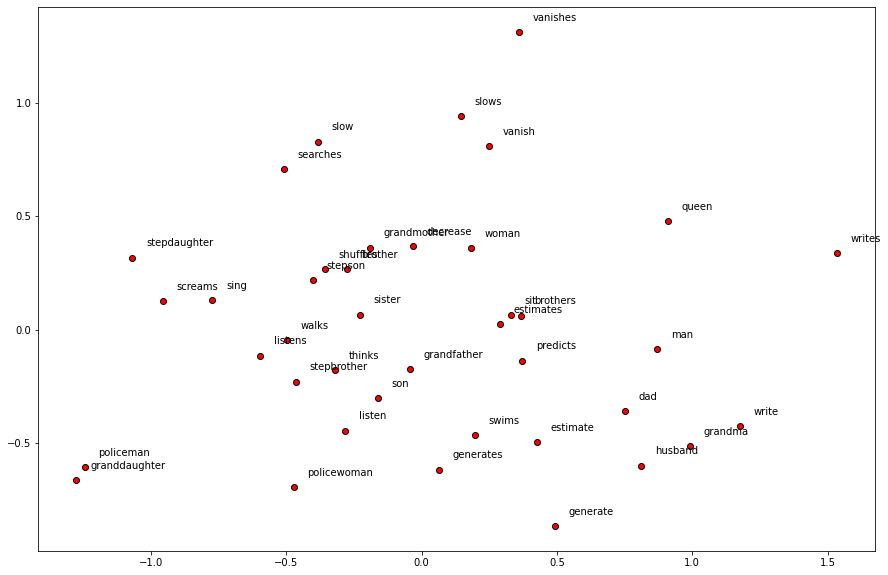

In [36]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
vec_word_bow = []
for oo in words :
    vec_word_bow.append(np.array(get_embed(oo, CBOW)))
word_vectors = vec_word
twodim = PCA().fit_transform(word_vectors)[:,:2]  #transform 4 to 2 dimensions

plt.figure(figsize=(15,10))
plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
for word, (x,y) in zip(words, twodim):
    plt.text(x+0.05, y+0.05, word)
plt.show()